In [1]:
import pandas as pd  
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
jsonObj = pd.read_json(path_or_buf='train.jsonl', lines=True)

In [2]:
jsonObj.head()

,text,label
0,The project will make a significant contributi...,1
1,"So in -- first of all, the segments, we are --...",0
2,Building a smarter and stronger energy grid th...,0
3,"Generally, first of all our Transmission depar...",0
4,"But for the most part, our challenge is showin...",0


#### EDA

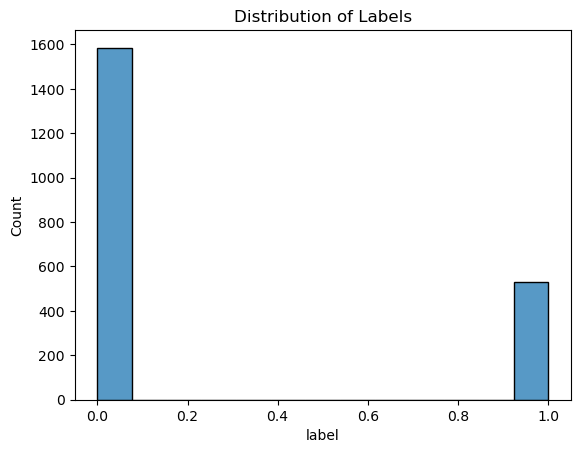

In [3]:
labels_hist=sns.histplot(data=jsonObj,
                      x='label')
plt.title('Distribution of Labels')
plt.show()

In [4]:
import nltk

# Download the lexicon
nltk.download("vader_lexicon")

# Import the lexicon 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tessanderson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
def format_output(output_dict):
    sentiment=False
    if(output_dict['compound']>0):
        sentiment=1
    else:
        sentiment=0
    return sentiment
def predict_sentiment(text):
    output_dict = sent_analyzer.polarity_scores(text)
    return format_output(output_dict)

# running the predictions
jsonObj['vader_prediction']=jsonObj['text'].apply(predict_sentiment)
jsonObj.sample(5)

,text,label,vader_prediction
1510,"As part of its investment policy, Legrand’s ma...",1,1
2107,With our full awareness of the current energy ...,0,1
443,Contacts for integrity-related questions and i...,0,1
1454,So the -- as part of the announced restructuri...,0,1
1159,So far with the spring/summer orders -- I'm ta...,0,0


In [6]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(jsonObj['label'],jsonObj['vader_prediction'])

print("Accuracy: {}\n".format(accuracy))

print(classification_report(jsonObj['label'],jsonObj['vader_prediction']))

Accuracy: 0.4723665564478035

              precision    recall  f1-score   support

           0       0.81      0.38      0.52      1585
           1       0.29      0.74      0.41       532

    accuracy                           0.47      2117
   macro avg       0.55      0.56      0.47      2117
weighted avg       0.68      0.47      0.49      2117



#### Textblob Sentiment Analysis

In [7]:
from textblob import TextBlob

In [8]:
def sentiment_analysis(text):
 def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity
  
 #Create a function to get the polarity
 def getPolarity(text):
   return TextBlob(text).sentiment.polarity
  
 #Create two new columns ‘Subjectivity’ & ‘Polarity’
 text['TextBlob_Subjectivity'] =    text['text'].apply(getSubjectivity)
 text ['TextBlob_Polarity'] = text['text'].apply(getPolarity)
 def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'
 text ['TextBlob_Analysis'] = text  ['TextBlob_Polarity'].apply(getAnalysis )
 return text

In [12]:
def sentiment_analysis(text):
 def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity
  
 #Create a function to get the polarity
 def getPolarity(text):
   return TextBlob(text).sentiment.polarity
  
 #Create two new columns ‘Subjectivity’ & ‘Polarity’
 text['TextBlob_Subjectivity'] =    text['text'].apply(getSubjectivity)
 text ['TextBlob_Polarity'] = text['text'].apply(getPolarity)
 def getAnalysis(score):
  if score <= 0:
    return 0
  else:
    return 1
 text ['TextBlob_Analysis'] = text  ['TextBlob_Polarity'].apply(getAnalysis )
 return text

In [13]:
tb_jsonObj=sentiment_analysis(jsonObj)

In [14]:
accuracy = accuracy_score(jsonObj['label'],tb_jsonObj['TextBlob_Analysis'])

print("Accuracy: {}\n".format(accuracy))

print(classification_report(jsonObj['label'],tb_jsonObj['TextBlob_Analysis']))

Accuracy: 0.4827586206896552

              precision    recall  f1-score   support

           0       0.74      0.48      0.58      1585
           1       0.24      0.50      0.33       532

    accuracy                           0.48      2117
   macro avg       0.49      0.49      0.45      2117
weighted avg       0.62      0.48      0.52      2117



#### Flair

In [36]:
import flair
from flair.models import TextClassifier
from flair.data import Sentence
from segtok.segmenter import split_single
import re

classifier = TextClassifier.load('en-sentiment')

In [30]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [31]:
def make_sentences(text):
    """ Break apart text into a list of sentences """
    sentences = [sent for sent in split_single(text)]
    return sentences

In [47]:
def predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    # stacked_embeddings.embed(text)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = text.to_dict()['labels'][0]['confidence']
    else:
        result = -(text.to_dict()['labels'][0]['confidence'])
    return round(result, 3)

In [33]:
def get_scores(sentences):
    """ Call predict on every sentence of a text """
    results = []
    
    for i in range(0, len(sentences)): 
        results.append(predict(sentences[i]))
    return results

def get_sum(scores):
    
    result = round(sum(scores), 3)
    return result

In [48]:
df = pd.read_json('train.jsonl', lines=True)
df = df.dropna()
df = df.reset_index(drop=True)
df.text = df.text.apply(clean)
df['sentences'] = df.text.apply(make_sentences)
df['scores'] = df['sentences'].apply(get_scores)
#df['scores_sum'] = df.scores.apply(get_sum)

KeyError: 'lass'